# Predictive Analytics Individual Coursework

In [572]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from joblib import dump, load
from tensorflow.keras.models import save_model, load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer

## 1. Preliminary Data Exploration

#### 1.1. Get the Data

In [573]:
cosmetics_df = pd.read_csv('cosmetics.csv', sep=",")
cosmetics_df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


#### 1.2. Observe the Data Structure

In [574]:
cosmetics_df.info()

cosmetics_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


,Price,Rank,Combination,Dry,Normal,Oily,Sensitive
count,1472.000000,1472.000000,1472.00000,1472.000000,1472.000000,1472.000000,1472.000000
mean,55.584239,4.153261,0.65625,0.614130,0.652174,0.607337,0.513587
std,45.014429,0.633918,0.47512,0.486965,0.476442,0.488509,0.499985
min,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,42.500000,4.300000,1.00000,1.000000,1.000000,1.000000,1.000000
75%,68.000000,4.500000,1.00000,1.000000,1.000000,1.000000,1.000000
max,370.000000,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [575]:

# Calculate counts of each attribute
product_type_counts = cosmetics_df['Label'].value_counts()
brand_counts = cosmetics_df['Brand'].value_counts()
skin_oily_counts = cosmetics_df['Oily'].value_counts()
skin_dry_counts = cosmetics_df['Dry'].value_counts()
skin_normal_counts = cosmetics_df['Normal'].value_counts()

# Convert counts to DataFrames
product_type_df = pd.DataFrame({'Product Type': product_type_counts.index, 'Count': product_type_counts.values})
brand_df = pd.DataFrame({'Brand': brand_counts.index, 'Count': brand_counts.values})
skin_oily_df = pd.DataFrame({'Oily Skin': ['Compatible', 'Not Compatible'], 'Count': skin_oily_counts.values})
skin_dry_df = pd.DataFrame({'Dry Skin': ['Compatible', 'Not Compatible'], 'Count': skin_dry_counts.values})
skin_normal_df = pd.DataFrame({'Normal Skin': ['Compatible', 'Not Compatible'], 'Count': skin_normal_counts.values})

# Display counts
print("Product Type Counts:")
print(tabulate(product_type_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nBrand Counts:")
print(tabulate(brand_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nOily Skin Counts:")
print(tabulate(skin_oily_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nDry Skin Counts:")
print(tabulate(skin_dry_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nNormal Skin Counts:")
print(tabulate(skin_normal_df, headers='keys', tablefmt='pretty', showindex=False))


Product Type Counts:
+--------------+-------+
| Product Type | Count |
+--------------+-------+
| Moisturizer  |  298  |
|   Cleanser   |  281  |
|  Face Mask   |  266  |
|  Treatment   |  248  |
|  Eye cream   |  209  |
| Sun protect  |  170  |
+--------------+-------+

Brand Counts:
+-------------------------------+-------+
|             Brand             | Count |
+-------------------------------+-------+
|           CLINIQUE            |  79   |
|      SEPHORA COLLECTION       |  66   |
|           SHISEIDO            |  63   |
|            ORIGINS            |  54   |
|             MURAD             |  47   |
|       PETER THOMAS ROTH       |  46   |
|      KIEHL'S SINCE 1851       |  46   |
|             FRESH             |  44   |
|           DR. JART+           |  41   |
|        KATE SOMERVILLE        |  35   |
|            LANCÔME            |  34   |
|         ESTÉE LAUDER          |  32   |
|           CAUDALIE            |  30   |
|         PERRICONE MD          |  30   |


## 2. Exploratory Data Analysis to Gain Insights


### 2.1. Preprocessing Cosmetic Product Data: Detecting Non-Ingredient Entries and Standardizing Ingredients List

In [576]:
# Ensure that the 'Ingredients' column is treated as a string
cosmetics_df['Ingredients'] = cosmetics_df['Ingredients'].astype(str)

# Split the ingredients into individual ingredients
# Convert to lowercase to avoid duplicate counts of each ingredient
all_ingredients = cosmetics_df['Ingredients'].str.lower().str.split(', ').explode()

# Get the total count of all ingredient occurrences
total_ingredients_count = all_ingredients.size

# Get the count of unique ingredients
unique_ingredients_count = all_ingredients.nunique()

# Display the counts
print(f'Total ingredients count: {total_ingredients_count}')
print(f'Unique ingredients count: {unique_ingredients_count}')

Total ingredients count: 45461
Unique ingredients count: 6833


In [577]:
#remove rows with non-ingredient information in the ingredient column
def contains_non_ingredient_data(entry):
    non_ingredient_keywords = ['visit', 'boutique', 'no info', 'information', '#name?']
    # Normalize the entry to lowercase and split if it's a string
    if isinstance(entry, str):
        entry = entry.lower().split(', ')
    # Check for non-ingredient keywords
    return any(keyword in item for item in entry for keyword in non_ingredient_keywords)

# Applying the function to identify rows with non-ingredient data
cosmetics_df['Contains_Non_Ingredient_Data'] = cosmetics_df['Ingredients'].apply(contains_non_ingredient_data)

# Filtering the dataframe to remove rows with non-ingredient data and drop the helper column
cosmetics_df_filtered = cosmetics_df[~cosmetics_df['Contains_Non_Ingredient_Data']].drop(columns=['Contains_Non_Ingredient_Data'])

# Display the new cleaned DataFrame
print(cosmetics_df_filtered.head())

         Label           Brand                                           Name  \
0  Moisturizer          LA MER                                Crème de la Mer   
1  Moisturizer           SK-II                       Facial Treatment Essence   
2  Moisturizer  DRUNK ELEPHANT                     Protini™ Polypeptide Cream   
3  Moisturizer          LA MER                    The Moisturizing Soft Cream   
4  Moisturizer    IT COSMETICS  Your Skin But Better™ CC+™ Cream with SPF 50+   

   Price  Rank                                        Ingredients  \
0    175   4.1  Algae (Seaweed) Extract, Mineral Oil, Petrolat...   
1    179   4.1  Galactomyces Ferment Filtrate (Pitera), Butyle...   
2     68   4.4  Water, Dicaprylyl Carbonate, Glycerin, Ceteary...   
3    175   3.8  Algae (Seaweed) Extract, Cyclopentasiloxane, P...   
4     38   4.1  Water, Snail Secretion Filtrate, Phenyl Trimet...   

   Combination  Dry  Normal  Oily  Sensitive  
0            1    1       1     1          1  
1   

In [578]:
#STANDARDIZE INGREDIENTS
def standardize_ingredients(ingredient_string):
    # Splitting and cleaning ingredient string
    ingredients = ingredient_string.lower().split(', ')
    ingredients = [ingredient.strip() for ingredient in ingredients]
    
    # Replacing synonyms
    synonym_dict = {'aqua': 'water', 'tocopherol': 'vitamin e', 'ascorbic acid': 'vitamin c'}
    ingredients = [synonym_dict.get(ingredient, ingredient) for ingredient in ingredients]

    # Removing any special characters, example '*'
    ingredients = [ingredient.replace('*', '') for ingredient in ingredients]
    
    return ingredients

# Applying the standardization function
cosmetics_df_filtered['Ingredients'] = cosmetics_df_filtered['Ingredients'].apply(standardize_ingredients)

# Display standardized ingredients
print(cosmetics_df_filtered['Ingredients'].head())

0    [algae (seaweed) extract, mineral oil, petrola...
1    [galactomyces ferment filtrate (pitera), butyl...
2    [water, dicaprylyl carbonate, glycerin, cetear...
3    [algae (seaweed) extract, cyclopentasiloxane, ...
4    [water, snail secretion filtrate, phenyl trime...
Name: Ingredients, dtype: object


### 2.2. Distributions of Numerical Attributes

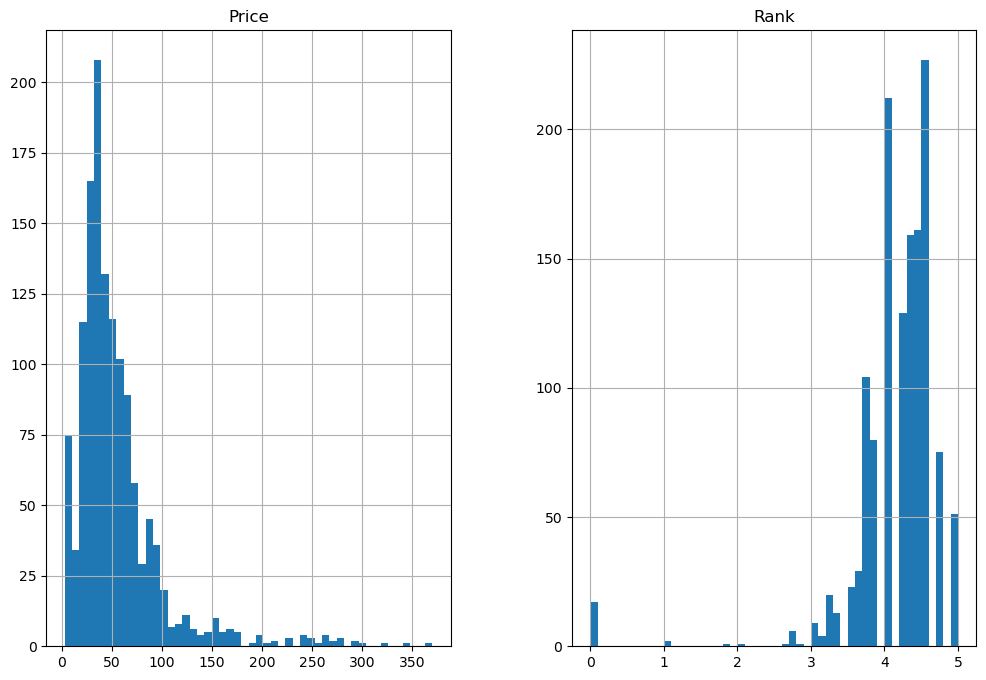

In [381]:
#understand distribution of Price and Rank

plt.rc('font', size=14)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

cosmetics_df_filtered[['Price', 'Rank']].hist(bins=50, figsize=(12, 8))
plt.show()

### 2.3. Categorical Attributes Analysis

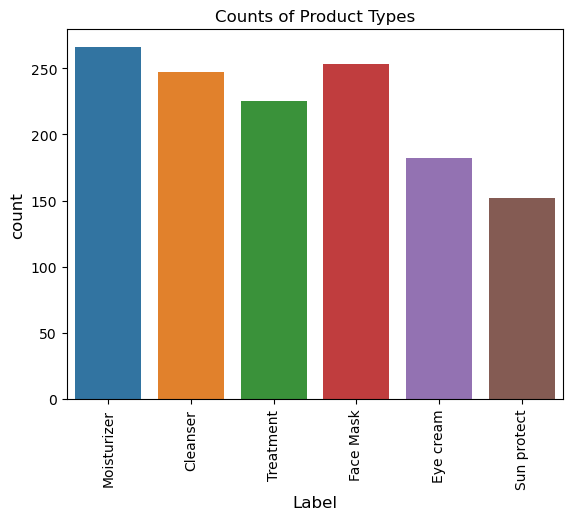

In [537]:
#3. Categorical Data Analysis
#visualize the frequency distribution of categorical variables to identify common and outlier categories.

sns.countplot(x=cosmetics_df_filtered['Label'])
plt.title('Counts of Product Types')
plt.xticks(rotation=90)
plt.show()


### 2.4. Skin Type Compatibility Analysis

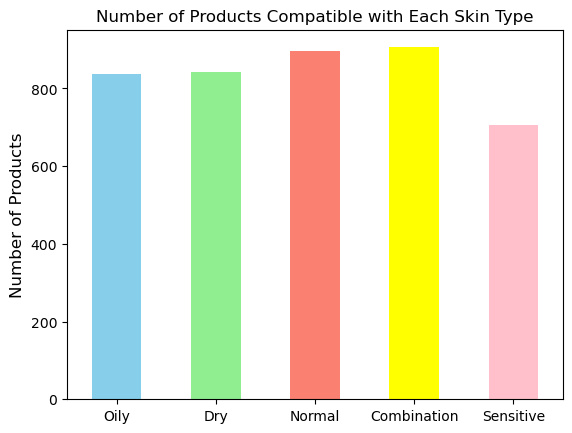

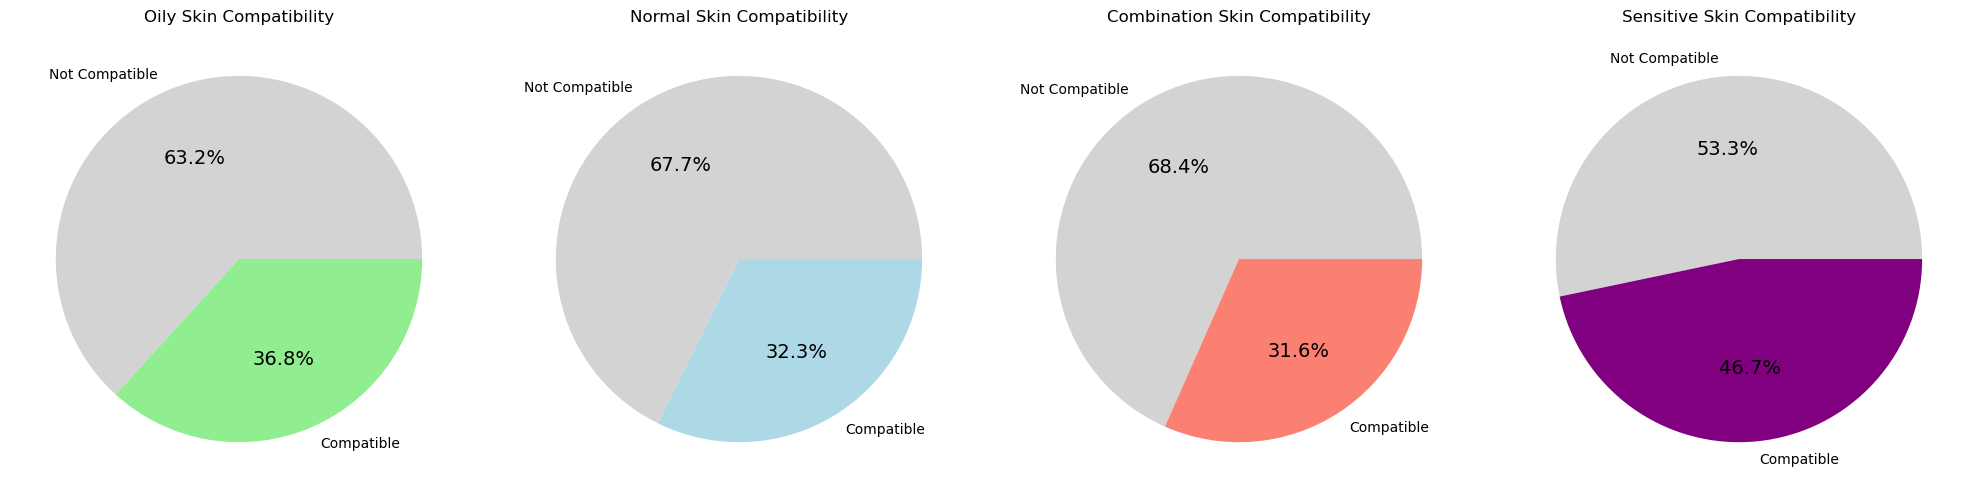

In [563]:

#Visualize how products are compatible with the different skin types present in the dataset - Oily, Normal, Sensitive and Combination
colors = ['skyblue', 'lightgreen', 'salmon', 'yellow', 'pink']
skin_type_compatibility = cosmetics_df_filtered[['Oily', 'Dry', 'Normal', 'Combination', 'Sensitive']].sum()
skin_type_compatibility.plot(kind='bar', stacked=True, color=colors)
plt.title('Number of Products Compatible with Each Skin Type')
plt.ylabel('Number of Products')
plt.xticks(rotation=0)
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Oily Skin Compatibility
oily_counts = cosmetics_df_filtered['Oily'].value_counts()
oily_counts.plot(kind='pie', labels=['Not Compatible', 'Compatible'], autopct='%1.1f%%', ax=axes[0], colors=['lightgray', 'lightgreen'])
axes[0].set_title('Oily Skin Compatibility')
axes[0].set_ylabel('')

# Normal Skin Compatibility
normal_counts = cosmetics_df_filtered['Normal'].value_counts()
normal_counts.plot(kind='pie', labels=['Not Compatible', 'Compatible'], autopct='%1.1f%%', ax=axes[1], colors=['lightgray', 'lightblue'])
axes[1].set_title('Normal Skin Compatibility')
axes[1].set_ylabel('')

# Combination Skin Compatibility
combination_counts = cosmetics_df_filtered['Combination'].value_counts()
combination_counts.plot(kind='pie', labels=['Not Compatible', 'Compatible'], autopct='%1.1f%%', ax=axes[2], colors=['lightgray', 'salmon'])
axes[2].set_title('Combination Skin Compatibility')
axes[2].set_ylabel('')

# Sensitive Skin Compatibility
sensitive_counts = cosmetics_df_filtered['Sensitive'].value_counts()
sensitive_counts.plot(kind='pie', labels=['Not Compatible', 'Compatible'], autopct='%1.1f%%', ax=axes[3], colors=['lightgray', 'purple'])
axes[3].set_title('Sensitive Skin Compatibility')
axes[3].set_ylabel('')

plt.tight_layout()
plt.show()


### 2.5. Price Comparison Across Skin Types

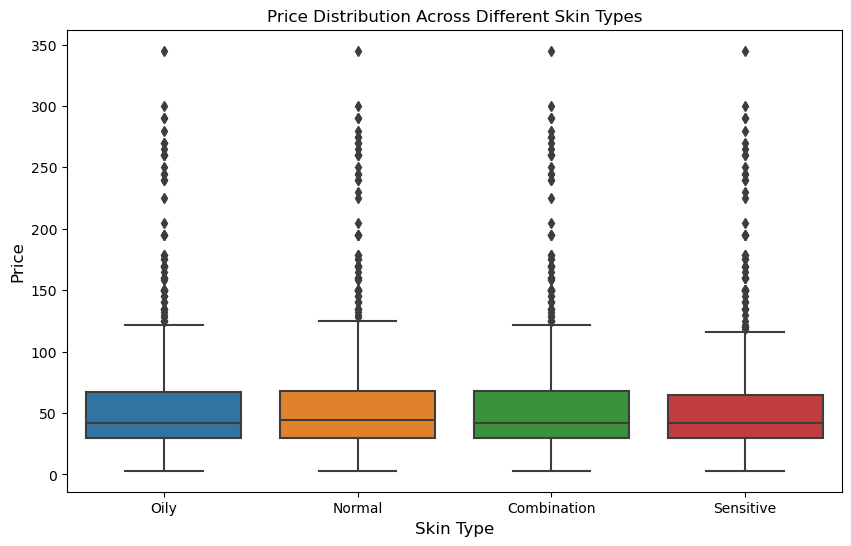

In [387]:
#Analyzse price differences across skin types and the relationship between the number of ingredients and prices.

melted_df = cosmetics_df_filtered.melt(value_vars=['Oily', 'Normal', 'Combination', 'Sensitive'], id_vars='Price', var_name='Skin_Type', value_name='Compatible')
filtered_melted_df = melted_df[melted_df['Compatible'] == 1]

# Visualise through a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Skin_Type', y='Price', data=filtered_melted_df)
plt.title('Price Distribution Across Different Skin Types')
plt.xlabel('Skin Type')
plt.ylabel('Price')
plt.show()


### 2.5. Relationship between Price and Ingredients

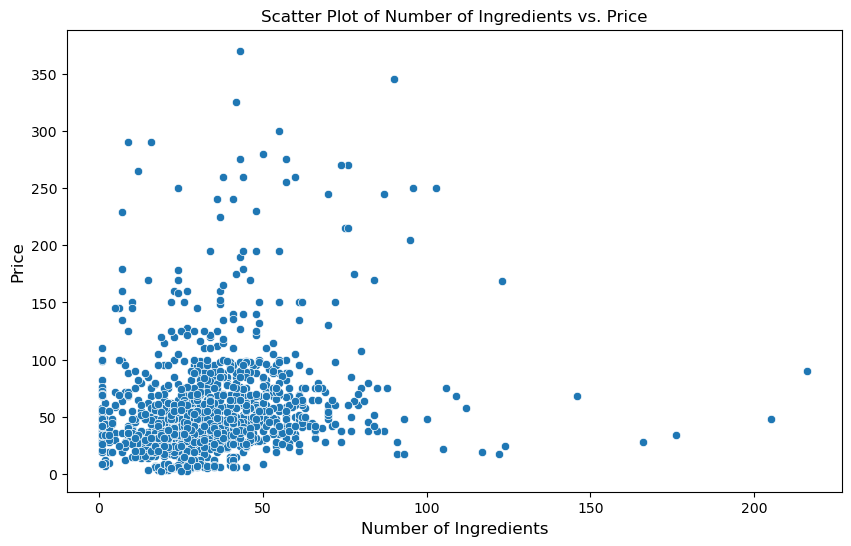

In [388]:
cosmetics_df_filtered['Number_of_Ingredients'] = cosmetics_df_filtered['Ingredients'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number_of_Ingredients', y='Price', data=cosmetics_df_filtered)
plt.title('Scatter Plot of Number of Ingredients vs. Price')
plt.xlabel('Number of Ingredients')
plt.ylabel('Price')
plt.show()

### 2.6 Ingredient Analysis Across Price Categories in Cosmetics

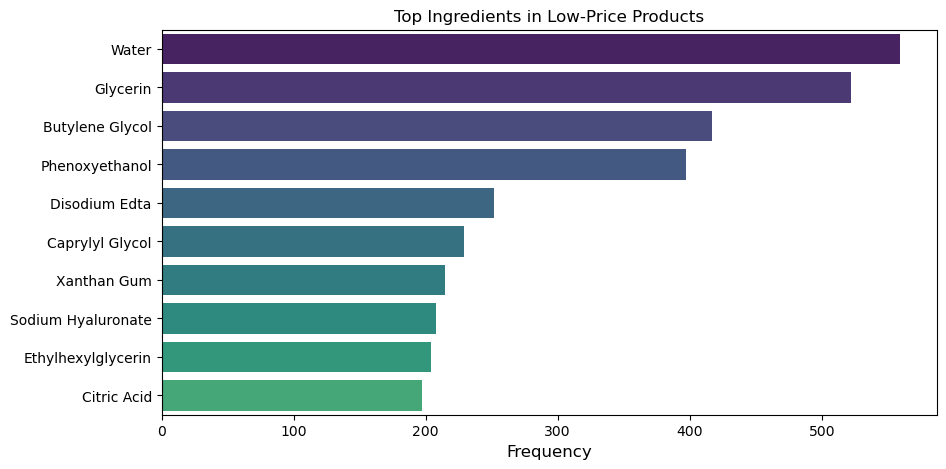

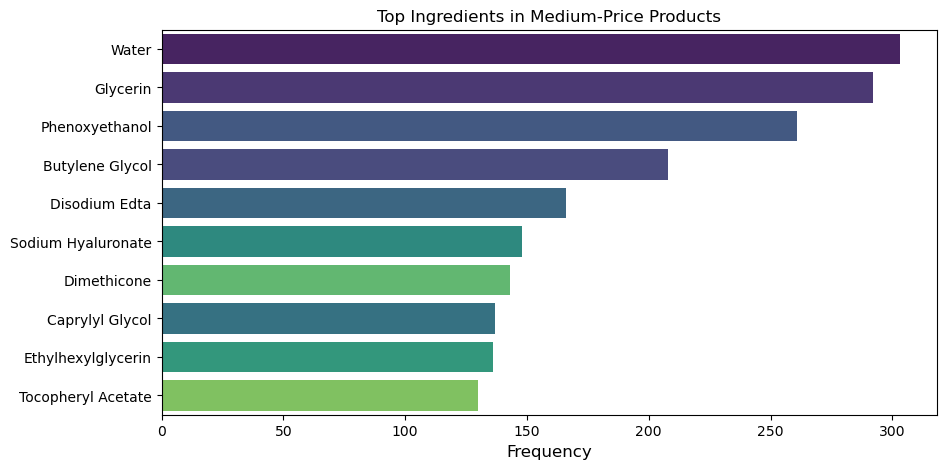

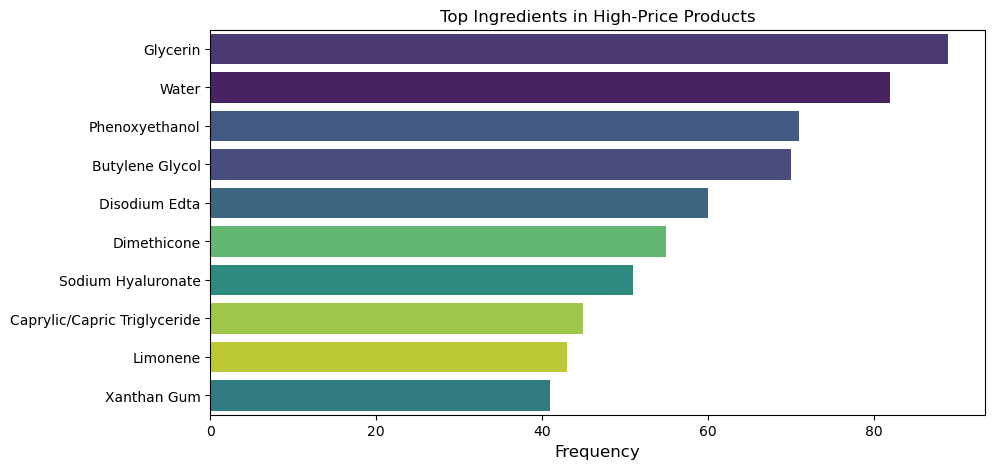

In [538]:

# Define price categories threshold
low_price = cosmetics_df[cosmetics_df['Price'] < 50]
medium_price = cosmetics_df[(cosmetics_df['Price'] >= 50) & (cosmetics_df['Price'] < 100)]
high_price = cosmetics_df[cosmetics_df['Price'] >= 100]

# Create a function to preprocess and flatten the ingredients lists
def preprocess_ingredients(ingredients_series):
    # Ensure all entries are strings, replace NaN with empty string
    ingredients_series = ingredients_series.fillna('').astype(str)
    # Flatten the list of ingredients
    return pd.Series(
        [ingredient for ingredient_list in ingredients_series.str.lower().str.split(', ')
         for ingredient in ingredient_list if ingredient]
    )

# Combine all top ingredients
all_top_ingredients = pd.concat([top_low_price_ingredients, top_medium_price_ingredients, top_high_price_ingredients])
unique_ingredients = all_top_ingredients.index.unique()
palette = sns.color_palette('viridis', n_colors=len(unique_ingredients))
color_mapping = dict(zip(unique_ingredients, palette))

#get the colour palette for the current top ingredients
def get_palette_for_current_ingredients(top_ingredients):
    return [color_mapping[ingredient] for ingredient in top_ingredients.index]

# Plot the top ingredients for low-price products with consistent colors
plt.figure(figsize=(10, 5))
sns.barplot(x=top_low_price_ingredients.values, y=top_low_price_ingredients.index, 
            palette=get_palette_for_current_ingredients(top_low_price_ingredients))
plt.title('Top Ingredients in Low-Price Products')
plt.xlabel('Frequency')
plt.show()

# Repeat the process for medium and high-price products
plt.figure(figsize=(10, 5))
sns.barplot(x=top_medium_price_ingredients.values, y=top_medium_price_ingredients.index, 
            palette=get_palette_for_current_ingredients(top_medium_price_ingredients))
plt.title('Top Ingredients in Medium-Price Products')
plt.xlabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_high_price_ingredients.values, y=top_high_price_ingredients.index, 
            palette=get_palette_for_current_ingredients(top_high_price_ingredients))
plt.title('Top Ingredients in High-Price Products')
plt.xlabel('Frequency')
plt.show()


### 2.7 Word Cloud of The Most Common Ingredients

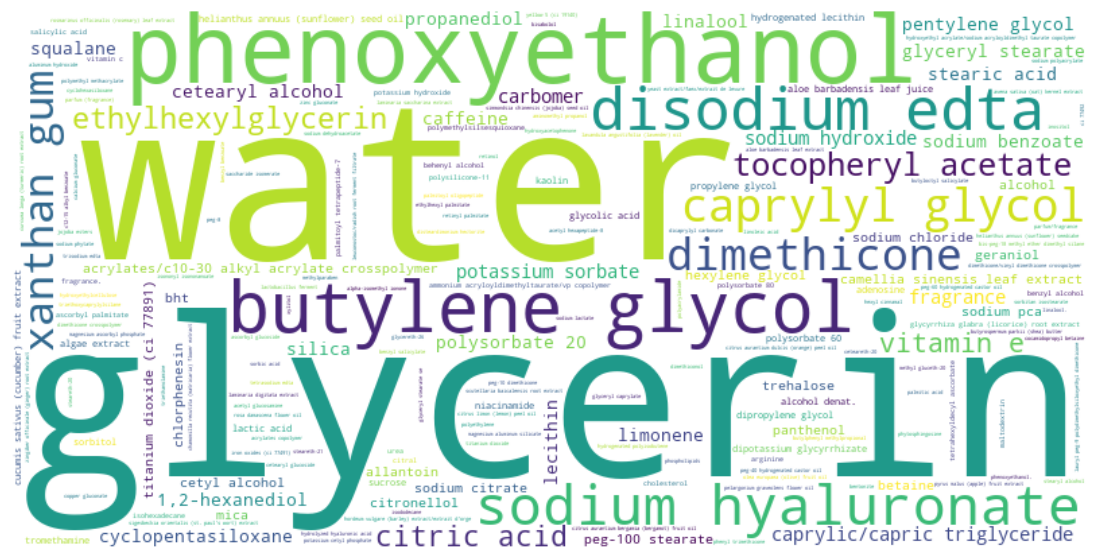

In [390]:

# Flatten the list of ingredients and calculate their frequency
ingredients = pd.Series([ingredient for sublist in cosmetics_df_filtered['Ingredients'].dropna() for ingredient in sublist])
ingredient_counts = ingredients.value_counts()

# Generate a word cloud for the most common ingredients
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ingredient_counts.to_dict())

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


### 2.7. Correlation Heatmap of Price, Rank, and Skin Types

                Price      Rank      Oily    Normal  Combination  Sensitive
Price        1.000000 -0.026892  0.001797  0.043138     0.006415   0.005104
Rank        -0.026892  1.000000  0.040486  0.064782     0.053971   0.030642
Oily         0.001797  0.040486  1.000000  0.825776     0.871875   0.616479
Normal       0.043138  0.064782  0.825776  1.000000     0.925500   0.695652
Combination  0.006415  0.053971  0.871875  0.925500     1.000000   0.667717
Sensitive    0.005104  0.030642  0.616479  0.695652     0.667717   1.000000


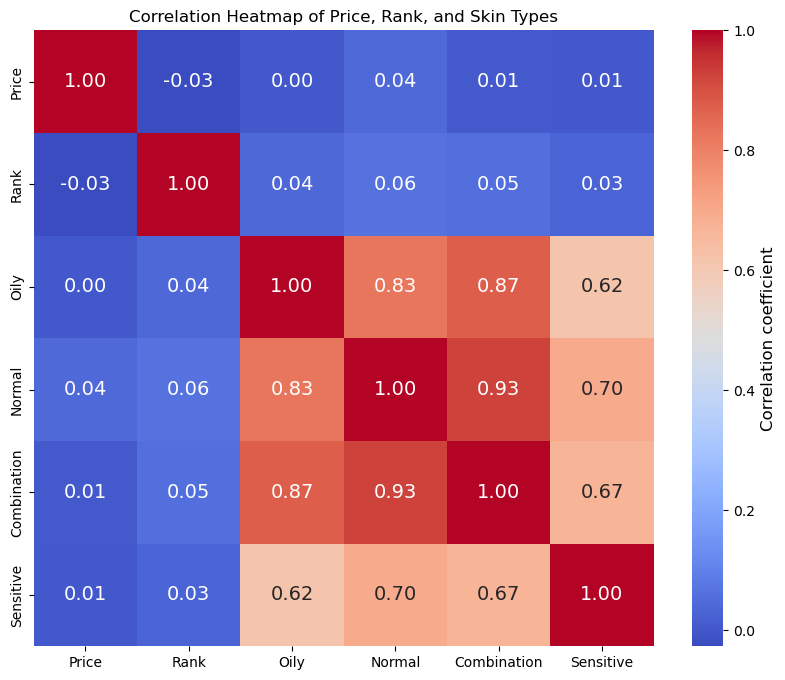

In [539]:
# Selecting only the relevant columns for the heatmap
data = cosmetics_df_filtered[['Price', 'Rank', 'Oily', 'Normal', 'Combination', 'Sensitive']]

# Calculate the correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Heatmap of Price, Rank, and Skin Types')
plt.show()

## 3. Data Cleaning and Preparation for Modelling
This section of the notebook focuses on preparing the cosmetic products dataset for machine learning modeling. The primary goal is to transform raw data into a format that can be efficiently utilized by predictive models.

#### 3.1. Convert Ingredients to Numeric Features using 'CountVectorizer'


In [392]:
#Convert the 'Ingredients' to Numeric Features that can be used by the machine learning algorithms.

# Transform any non-string data to string
if 'Ingredients' in cosmetics_df_filtered.columns:
    cosmetics_df_filtered['Ingredients'] = cosmetics_df_filtered['Ingredients'].astype(str)

# Create a CountVectorizer object for binary counts
count_vectorizer = CountVectorizer(binary=True)

# Fit and transform the 'Ingredients' column
ingredients_counts = count_vectorizer.fit_transform(cosmetics_df_filtered['Ingredients'])

# Convert the resulting matrix to a DataFrame
ingredients_counts_df = pd.DataFrame(ingredients_counts.toarray(), columns=count_vectorizer.get_feature_names_out())


#### 3.2. Concatenate Feature Set

In [541]:
# Reset indices to ensure alignment
ingredients_counts_df.reset_index(drop=True, inplace=True)
cosmetics_df_filtered.reset_index(drop=True, inplace=True)

# Fill NaN values in cosmetics_df_filtered before concatenation by using mode for categorical data and median for numerical data
for column in cosmetics_df_filtered.columns:
    if cosmetics_df_filtered[column].dtype == 'object':  # Assuming object dtype implies categorical
        cosmetics_df_filtered[column].fillna(cosmetics_df_filtered[column].mode()[0], inplace=True)
    else:  # For numerical data
        cosmetics_df_filtered[column].fillna(cosmetics_df_filtered[column].median(), inplace=True)

# Concatenate the DataFrames
cosmetics_final_df = pd.concat([ingredients_counts_df, cosmetics_df_filtered.drop('Ingredients', axis=1)], axis=1)

# Check for NaN values again
nan_counts_after_concat = cosmetics_final_df.isna().sum().sum()
print(f"Total NaN values in the final DataFrame after concatenation: {nan_counts_after_concat}")

# Display the DataFrame to view the new changes
print(cosmetics_final_df.head())


Total NaN values in the final DataFrame after concatenation: 0
   00  000  002  01  02  031  05  067  07  074  ...        Label  \
0   0    0    0   0   0    0   0    0   0    0  ...  Moisturizer   
1   0    0    0   0   0    0   0    0   0    0  ...  Moisturizer   
2   0    0    0   0   0    0   0    0   0    0  ...  Moisturizer   
3   0    0    0   0   0    0   0    0   0    0  ...  Moisturizer   
4   0    0    0   0   0    0   0    0   0    0  ...  Moisturizer   

            Brand                                           Name  Price  Rank  \
0          LA MER                                Crème de la Mer    175   4.1   
1           SK-II                       Facial Treatment Essence    179   4.1   
2  DRUNK ELEPHANT                     Protini™ Polypeptide Cream     68   4.4   
3          LA MER                    The Moisturizing Soft Cream    175   3.8   
4    IT COSMETICS  Your Skin But Better™ CC+™ Cream with SPF 50+     38   4.1   

   Combination  Dry  Normal  Oily  Sensit

#### 3.3. Handling Numerically Named Columns
Identifying and managing columns that might result from transformations applied during preprocessing and do not contribute to the predictive power of any ML models.

In [542]:
#removing columns that have results from the CountVectorizer process applied during preprocessing
#removing to simplify the analysis and improve the models
#Identify numeric-named columns
numeric_named_cols = [col for col in cosmetics_final_df.columns if col.isdigit()]

# Display these columns to review their content
print(cosmetics_final_df[numeric_named_cols].head())

   00  000  002  01  02  031  05  067  07  074  ...  77891  77947  78  80  \
0   0    0    0   0   0    0   0    0   0    0  ...      0      0   0   0   
1   0    0    0   0   0    0   0    0   0    0  ...      0      0   0   0   
2   0    0    0   0   0    0   0    0   0    0  ...      0      0   0   0   
3   0    0    0   0   0    0   0    0   0    0  ...      0      0   0   0   
4   0    0    0   0   0    0   0    0   0    0  ...      0      0   0   0   

   800  81  85  90  94  993  
0    0   0   0   0   0    0  
1    0   0   0   0   0    0  
2    0   0   0   0   0    0  
3    0   0   0   0   0    0  
4    0   0   0   0   0    0  

[5 rows x 119 columns]


In [543]:
# Identify and drop columns where the name contains digits
columns_to_drop = [column for column in cosmetics_final_df.columns if any(char.isdigit() for char in column) and cosmetics_final_df[column].dtype == float]
cosmetics_final_df.drop(columns=columns_to_drop, inplace=True)
print(f"Columns containing numbers in their names and stored as float have been deleted: {columns_to_drop}")


Columns containing numbers in their names and stored as float have been deleted: []


#### 3.4. Removing Features with Low Presence
This step helps reduce model complexity and improve performance by filtering out features that do not vary much across the dataset.

In [544]:
#Removing features with low variation to reduce the model's complexity and improve performance:

# Define columns to exclude from the filtering process
excluded_columns = ['Label', 'Brand', 'Name', 'Price', 'Rank']

# List of columns to check for occurrences of 1, which is the presence of an ingredient
binary_feature_columns = [col for col in cosmetics_final_df.columns if col not in excluded_columns]

# Count the occurrences of '1' in each binary feature
counts = cosmetics_final_df[binary_feature_columns].sum()

# Filter out columns with fewer than 300 occurrences of '1' - threshold for ingredient importance
columns_to_drop = counts[counts < 300].index
cosmetics_final_df.drop(columns=columns_to_drop, inplace=True)
print("Dropped Columns:", columns_to_drop)
print(cosmetics_final_df.shape)
print(cosmetics_final_df.columns)


Dropped Columns: Index(['00', '000', '002', '01', '02', '031', '05', '067', '07', '074',
       ...
       'zerumbet', 'zeylanicum', 'zinc', 'zingiber', 'zingier', 'zizanoides',
       'ziziphus', 'zizyphus', 'zolinone', 'zostera'],
      dtype='object', length=4414)
(1325, 57)
Index(['20', 'acetate', 'acid', 'acrylate', 'alcohol', 'benzoate', 'butylene',
       'capric', 'caprylic', 'caprylyl', 'carbomer', 'ci', 'citric', 'citrus',
       'copolymer', 'crosspolymer', 'dimethicone', 'disodium', 'edta',
       'ethylhexylglycerin', 'extract', 'flower', 'fragrance', 'fruit',
       'glycerin', 'glyceryl', 'glycol', 'gum', 'hyaluronate', 'hydrogenated',
       'hydroxide', 'leaf', 'oil', 'peg', 'phenoxyethanol', 'polysorbate',
       'potassium', 'root', 'seed', 'sodium', 'sorbate', 'stearate',
       'tocopheryl', 'triglyceride', 'vitamin', 'water', 'xanthan', 'Label',
       'Brand', 'Name', 'Price', 'Rank', 'Combination', 'Dry', 'Normal',
       'Oily', 'Sensitive'],
      dtype='objec

#### Step 3: Normalise the Price Column

In [546]:
#Normalise the Price to ensure it's on a similar scale to other features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normalize the 'Price' column
cosmetics_final_df['price_normalized'] = scaler.fit_transform(cosmetics_final_df[['Price']])

# Check the new normalized price
print(cosmetics_final_df[['Price', 'price_normalized']].head())


   Price  price_normalized
0    175          0.468665
1    179          0.479564
2     68          0.177112
3    175          0.468665
4     38          0.095368


#### Step 4: Prepare Data for Modelling

In [547]:
from sklearn.model_selection import train_test_split

# Define columns to exclude from the model
excluded_columns = ['Rank', 'Label', 'Name', 'price_normalized', 'Price', 'Brand', 'price_standardized', 'Number_of_Ingredients']

# Drop non-numeric columns (assuming they are known and listed in excluded_columns)
X = cosmetics_final_df.drop(columns=excluded_columns, errors='ignore')
y = cosmetics_final_df['price_normalized']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the new dataset to a CSV file
new_file_path = 'new_cosmetics_data1.csv'
cosmetics_final_df.to_csv(new_file_path, index=False)

## Part 3. Exploring different models 

### Linear Regression Model

In [548]:
# Create a linear regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.01226299711035574
R-squared (R2) Score: 0.17266453902478396


### Cross-Validation Linear Regression Model

In [499]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Create a linear regression model
lr_model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean squared error
mse_mean = -cv_scores.mean()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr_model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE) after cross-validation:", mse_mean)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE) after cross-validation: 0.0129118918674194
R-squared (R2) Score: 0.17266453902478396


### Decision Tree Model

In [549]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the decision tree regressor
cosmetics_decision_tree = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
cosmetics_decision_tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = cosmetics_decision_tree.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.022385278857336825
R-squared: -0.5102454021500022


### Random Forest Model

In [550]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
cosmetics_random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
cosmetics_random_forest.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = cosmetics_random_forest.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)


Random Forest Mean Squared Error: 0.010869042379672976
Random Forest R-squared: 0.2667091000166565


### Cross-Validation Random Forest

In [502]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest regressor
cosmetics_random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cosmetics_random_forest, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean squared error
mse_mean = -cv_scores.mean()

# Fit the model on the training data
cosmetics_random_forest.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = cosmetics_random_forest.predict(X_test)

# Calculate R-squared score
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print("Random Forest Mean Squared Error (MSE) after cross-validation:", mse_mean)
print("Random Forest R-squared (R2) Score:", r2_rf)


Random Forest Mean Squared Error (MSE) after cross-validation: 0.011844715732126367
Random Forest R-squared (R2) Score: 0.2667091000166565


### Support Vector Regression (SVR) Model

In [503]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Support Vector Regressor
cosmetics_svr_regressor = SVR(kernel='rbf', C=1.0, gamma='scale')

# Fit the SVR model on the training data
cosmetics_svr_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_svr = cosmetics_svr_regressor.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print results
print("Support Vector Machine Mean Squared Error (MSE):", mse_svr)
print("Support Vector Machine R-squared (R2) Score:", r2_svr)


Support Vector Machine Mean Squared Error (MSE): 0.012691950176468292
Support Vector Machine R-squared (R2) Score: 0.1437247880409671


In [504]:
from sklearn.model_selection import cross_val_score

# Initialize the Support Vector Regressor
cosmetics_svm_regressor = SVR(kernel='rbf', C=1.0, gamma='scale')  # Using the best hyperparameters found in GridSearchCV

# Perform cross-validation
cv_scores = cross_val_score(cosmetics_svm_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values and calculate mean MSE
mean_mse_cv = -np.mean(cv_scores)

# Print the mean MSE
print("Mean Cross-Validated MSE:", mean_mse_cv)

# Calculate the mean R-squared score
mean_r2_cv = np.mean(cv_scores)

# Print the mean R-squared score
print("Mean Cross-Validated R-squared:", mean_r2_cv)


Mean Cross-Validated MSE: 0.014752844711407653
Mean Cross-Validated R-squared: -0.014752844711407653


## Base Neural Network

In [551]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def base_cosmetics_nn(X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize the neural network model
    model = Sequential()

    # Add input layer
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Add hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Add output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model on the training data
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions on the testing data
    y_pred = model.predict(X_test_scaled)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred.flatten()) 
    print("Mean Squared Error (MSE):", mse)

    # Calculate R-squared (R2)
    r2 = r2_score(y_test, y_pred.flatten())
    print("R-squared (R2):", r2)

    return model, mse, r2

# Call the function with scaled data
base_model, base_mse, base_r2 = base_cosmetics_nn(X_train_scaled, y_train, X_test_scaled, y_test)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3756 - val_loss: 0.1615
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.1000 - val_loss: 0.0980
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0558 - val_loss: 0.0795
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0390 - val_loss: 0.0698
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0265 - val_loss: 0.0634
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0231 - val_loss: 0.0643
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0170 - val_loss: 0.0565
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0164 - val_loss: 0.0562
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0533
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0095 - val_loss: 0.0530
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0086 - val_loss: 0.0525
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - l

### Improvement 1: Optimising Parameters, Activation Function, Dropout Layers

In [553]:
#increasing the number of neurons to 128
#add dropout layers after each hidden layer to prevent overfitting
#adjusted the activation function to ReLU
#Retained linear activation for the output layer.

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load

# Initialize the neural network model
cosmetics_nn_1 = Sequential()

# Add input layer using Input() object
cosmetics_nn_1.add(Input(shape=(X_train_scaled.shape[1],)))

# Add hidden layers with dropout regularization
cosmetics_nn_1.add(Dense(128, activation='relu'))
cosmetics_nn_1.add(Dropout(0.2))
cosmetics_nn_1.add(Dense(64, activation='relu'))
cosmetics_nn_1.add(Dropout(0.2))
cosmetics_nn_1.add(Dense(32, activation='relu'))
cosmetics_nn_1.add(Dropout(0.2))

# Add output layer
cosmetics_nn_1.add(Dense(1, activation='linear'))

# Compile the model
cosmetics_nn_1.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model on the training data
history = cosmetics_nn_1.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions on the testing data
y_pred = cosmetics_nn_1.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4137 - val_loss: 0.0364
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0858 - val_loss: 0.0258
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0658 - val_loss: 0.0193
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0438 - val_loss: 0.0174
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 - val_loss: 0.0160
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0320 - val_loss: 0.0157
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0259 - val_loss: 0.0153
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.0225 - val_loss: 0.0147
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0246 - val_loss: 0.0144
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183 - val_loss: 0.0141
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0200 - val_loss: 0.0139
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183 - 

### Improvement 2: Adding Early Stopping and Regularization: Neural Network 2

In [514]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the neural network model
cosmetics_nn_2 = Sequential()

# Add input layer with Input(shape)
cosmetics_nn_2.add(Input(shape=(X_train_scaled.shape[1],)))

# Add hidden layers 
cosmetics_nn_2.add(Dense(128, activation='relu'))
cosmetics_nn_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
cosmetics_nn_2.add(Dropout(0.1))
cosmetics_nn_2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
cosmetics_nn_2.add(Dropout(0.1))

# Add output layer
cosmetics_nn_2.add(Dense(1, activation='linear'))

# Compile the model
cosmetics_nn_2.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model on the training data with early stopping
history = cosmetics_nn_2.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                            validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Make predictions on the testing data
y_pred = cosmetics_nn_2.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4741 - val_loss: 1.1560
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1190 - val_loss: 0.9642
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9278 - val_loss: 0.7923
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7577 - val_loss: 0.6438
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.6133 - val_loss: 0.5206
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.4968 - val_loss: 0.4195
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3977 - val_loss: 0.3383
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.3193 - val_loss: 0.2731
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.2575 - val_loss: 0.2211
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.2086 - val_loss: 0.1799
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.1687 - val_loss: 0.1473
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/

### Improvement 3: Adjust Learning Rate (ReduceOnPlateau): Neural Network 3

In [515]:
#the learning rate is adjusted dynamically using the ReduceLROnPlateau callback, which reduces the learning rate by a factor of 0.2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the neural network model
cosmetics_nn_final = Sequential()

# Add input layer explicitly
cosmetics_nn_final.add(Input(shape=(X_train_scaled.shape[1],)))

# Add the first dense layer 
cosmetics_nn_final.add(Dense(128, activation='relu'))

# Add hidden layers with dropout regularization and L2 regularization
cosmetics_nn_final.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
cosmetics_nn_final.add(Dropout(0.2))  # Dropout rate unchanged
cosmetics_nn_final.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
cosmetics_nn_final.add(Dropout(0.2))  # Dropout rate unchanged

# Add output layer
cosmetics_nn_final.add(Dense(1, activation='linear'))

# Compile the model
cosmetics_nn_final.compile(loss='mean_squared_error', optimizer='adam')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Fit the model on the training data with callbacks
history = cosmetics_nn_final.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                                 validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Make predictions on the testing data
y_pred = cosmetics_nn_final.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)



Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4153 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1029 - val_loss: 0.9471 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9095 - val_loss: 0.7725 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7390 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5912 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.4681 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3709 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.2938 - val_loss: 0.2448 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.2315 - val_loss: 0.1931 - learning_rate: 0.0010
Epoch 10/100


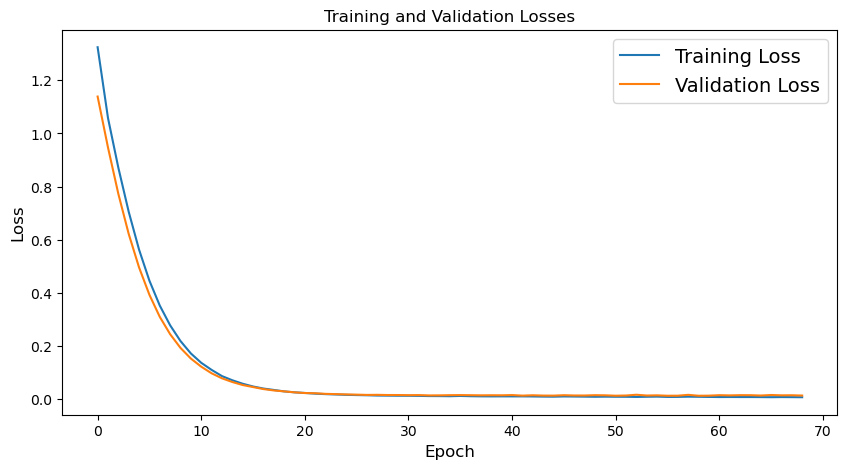

In [516]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on Neural Network 2

In [522]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Ensure y_train is a numpy array
y_train_np = np.array(y_train)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_kf, X_val_kf = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_kf, y_val_kf = y_train_np[train_index], y_train_np[val_index]

    # Create the model using the input shape
    nn_model = create_model(X_train_kf.shape[1])

    # Setup the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model using the training part of the fold
    nn_model.fit(X_train_kf, y_train_kf, epochs=100, batch_size=32,
                 validation_data=(X_val_kf, y_val_kf), callbacks=[early_stopping], verbose=0)

    # Predict on the validation part of the fold and evaluate
    y_pred_kf = nn_model.predict(X_val_kf).flatten()
    mse = mean_squared_error(y_val_kf, y_pred_kf)
    r2 = r2_score(y_val_kf, y_pred_kf)

# Calculate the average scores across all folds
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

# Output cross-validation results
print(f"Average Mean Squared Error (MSE) from CV: {average_mse}")
print(f"Average R-squared (R2) from CV: {average_r2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average Mean Squared Error (MSE) from CV: 0.0116535842336001
Average R-squared (R2) from CV: 0.19583991386946029


## Part 5. Fine-tuning Best Models

### 5.1. Random Forest GridSearch

In [518]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest regressor
cosmetics_random_forest = RandomForestRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],  # Use valid settings for max_features
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=cosmetics_random_forest, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best model
best_cosmetics_random_forest = grid_search.best_estimator_

# Make predictions with the best model
y_pred_rf_best = best_cosmetics_random_forest.predict(X_test)

# Evaluate the best model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations in the test dataset
p = X_test.shape[1]  # number of predictors
adjusted_r2_rf_best = 1 - ((1 - r2_rf_best) * (n - 1) / (n - p - 1))

# Print the performance of the final model
print("Best parameters found: ", grid_search.best_params_)
print("Best Random Forest Mean Squared Error (MSE):", mse_rf_best)
print("Best Random Forest R-squared:", r2_rf_best)
print("Best Random Forest Mean Absolute Error (MAE):", mae_rf_best)

# Save the results
dump((mse_rf_best, r2_rf_best, mae_rf_best), 'rf_model_performance.joblib')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Mean Squared Error (MSE): 0.011244232750085903
Best Random Forest R-squared: 0.24139650349024044
Best Random Forest Mean Absolute Error (MAE): 0.06898697447359163


['rf_model_performance.joblib']

#### Visualise Feature Importance based on Random Forest

Random Forest Mean Squared Error (MSE): 0.011244232750085903
Random Forest R-squared: 0.24139650349024044
Random Forest Mean Absolute Error (MAE): 0.06898697447359163


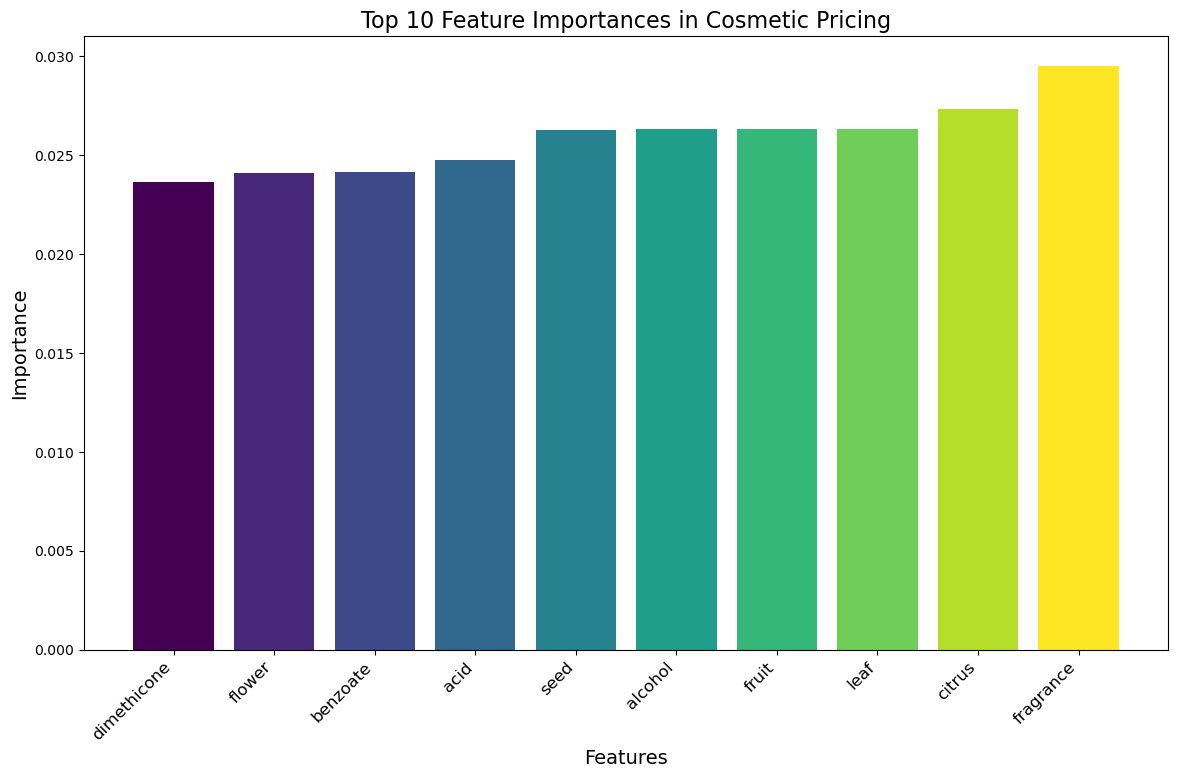

In [521]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the RandomForestRegressor with the best parameters found from GridSearch
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)

# Fit the model on your training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Output the performance
print(f"Random Forest Mean Squared Error (MSE): {mse}")
print(f"Random Forest R-squared: {r2}")
print(f"Random Forest Mean Absolute Error (MAE): {mae}")

# Retrieve feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Get the indices of the top 10 features

# Define a color map
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Plotting the top 10 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 10 Feature Importances in Cosmetic Pricing", fontsize=16)
bars = plt.bar(range(10), importances[indices], color=colors, align='center')
plt.xticks(range(10), X_train.columns[indices], rotation=45, ha="right", fontsize=12)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.tight_layout()
plt.show()


### 5.2. MLP Neural Network RandomizedSearch

In [523]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from joblib import dump

# Define the function to create the model
def create_model(n_units=128, dropout_rate=0.2, regularization=0.01, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(n_units, activation='relu', kernel_regularizer=l2(regularization)),
        Dropout(dropout_rate),
        Dense(int(n_units / 2), activation='relu', kernel_regularizer=l2(regularization)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, epochs=100, batch_size=32, verbose=0,
                       validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                                         ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)])

# Define the random search parameter grid space
param_distributions = {
    'model__n_units': [64, 128, 256, 512],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__regularization': [0.01, 0.005, 0.02, 0.001],
    'model__learning_rate': [0.01, 0.001, 0.0001, 0.00001]
}

# Set the number of iterations for the RandomizedSearchCV
n_iter = 20

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=n_iter, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
random_search.fit(X_train_scaled, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)

# Retrieve the best model
best_model = random_search.best_estimator_.model_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_scaled)
mse_nn_final = mean_squared_error(y_test, y_pred)
r2_nn_final = r2_score(y_test, y_pred)
mae_nn_final = mean_absolute_error(y_test, y_pred)

# Print the performance of the final model
print("Final Model Mean Squared Error (MSE):", mse_nn_final)
print("Final Model R-squared (R2):", r2_nn_final)
print("Final Model Mean Absolute Error (MAE):", mae_nn_final)

#Save the results to disk
dump((mse_nn_final, r2_nn_final, mae_nn_final), 'nn_model_performance.joblib')


/Users/elena/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'model__regularization': 0.005, 'model__n_units': 256, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.5}
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Model Mean Squared Error (MSE): 0.011105350843954497
Final Model R-squared (R2): 0.2507663112783637
Final Model Mean Absolute Error (MAE): 0.06938678634526164


['nn_model_performance.joblib']

#### Actual vs Predicted Plot for the fine-tuned Neural Network

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


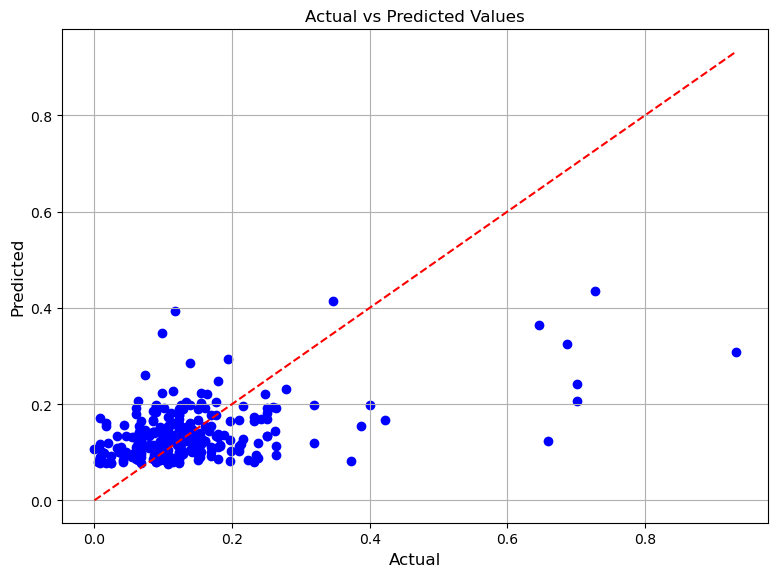

In [524]:
import matplotlib.pyplot as plt

# Load the model obtained from randomized search
best_model = random_search.best_estimator_.model_

# Make predictions on the test data
y_pred = best_model.predict(X_test_scaled)

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Final Model Comparison and Solution

In [564]:
from joblib import dump, load

# Save MSE, MAE, and R-squared values using Joblib
dump([mse_rf, mae_rf, r2_rf, mse_nn_final, mae_nn_final, r2_nn_final], 'model_metrics.joblib')

# Load MSE, MAE, and R-squared values
mse_rf_loaded, mae_rf_loaded, r2_rf_loaded, mse_nn_loaded, mae_nn_loaded, r2_nn_loaded = load('model_metrics.joblib')

# Print the loaded values
print("Random Forest:")
print("MSE:", mse_rf_loaded)
print("MAE:", mae_rf_loaded)
print("R-squared:", r2_rf_loaded)

print("\nNeural Network:")
print("MSE:", mse_nn_loaded)
print("MAE:", mae_nn_loaded)
print("R-squared:", r2_nn_loaded)



Random Forest:
MSE: 0.010869042379672976
MAE: 0.07240227473194448
R-squared: 0.2667091000166565

Neural Network:
MSE: 0.011105350843954497
MAE: 0.06938678634526164
R-squared: 0.2507663112783637


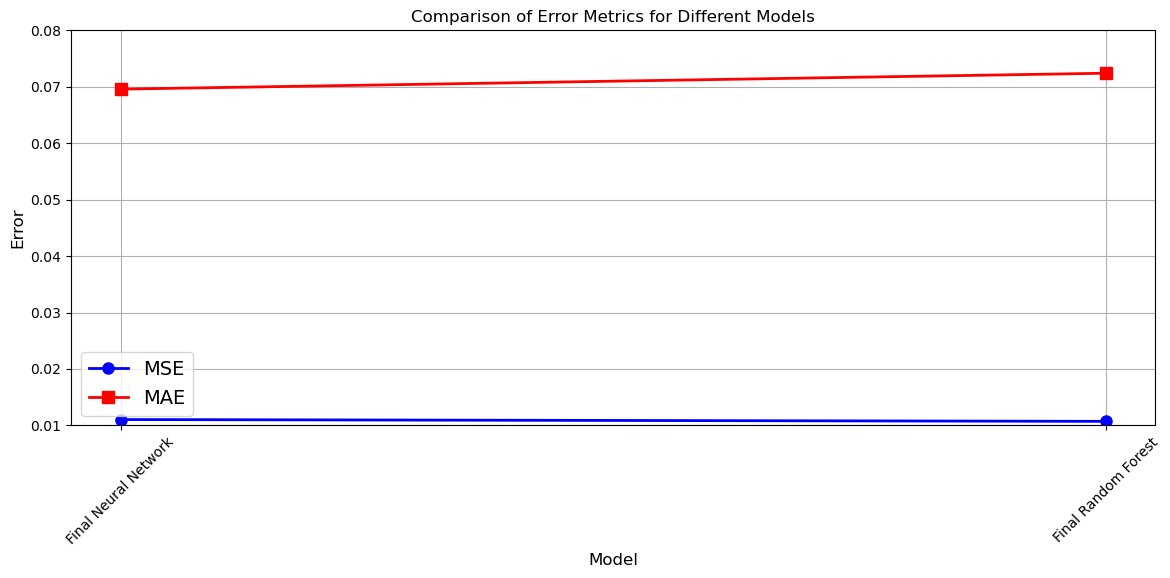

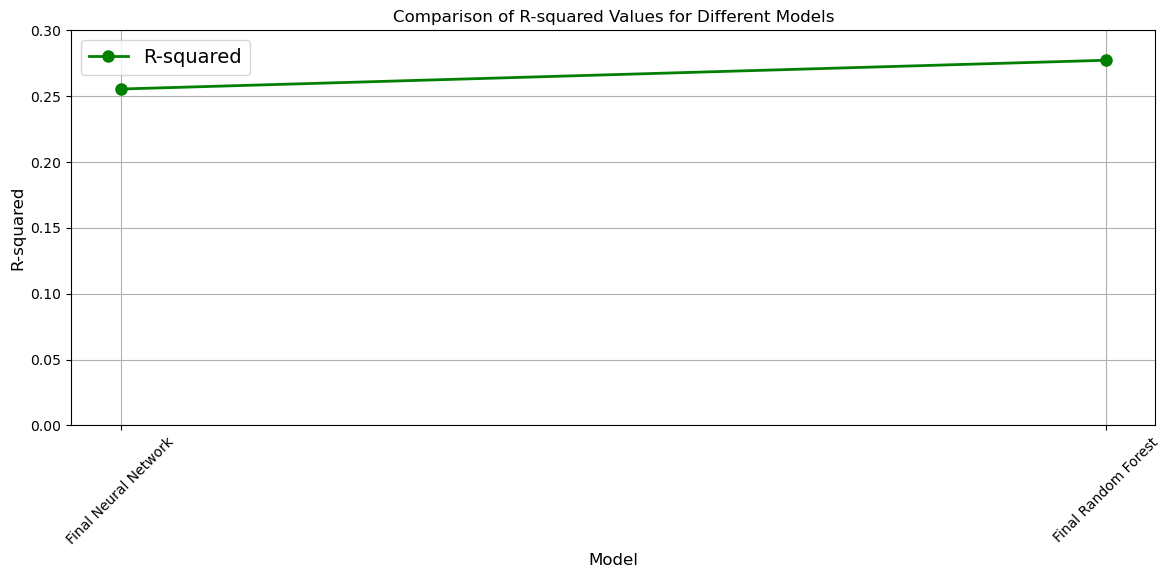

In [571]:


# Load MSE, MAE, and R-squared values for each model
mse_nn_loaded, mae_nn_loaded, r2_nn_loaded = 0.011036362560931918, 0.06958081048114319, 0.255420675331681
mse_rf_loaded, mae_rf_loaded, r2_rf_loaded = 0.010712269135368416, 0.07240227473194448, 0.2772859649688436

# Model names
models = ['Final Neural Network', 'Final Random Forest']

# MSE, MAE, and R-squared values
mse_values = [mse_nn_loaded, mse_rf_loaded]
mae_values = [mae_nn_loaded, mae_rf_loaded]
r2_values = [r2_nn_loaded, r2_rf_loaded]

# Plotting MSE and MAE values
plt.figure(figsize=(12, 6))
plt.plot(models, mse_values, 'o-', color='blue', linewidth=2, markersize=8, label='MSE')
plt.plot(models, mae_values, 's-', color='red', linewidth=2, markersize=8, label='MAE')
plt.title('Comparison of Error Metrics for Different Models')
plt.xlabel('Model')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0.01, 0.08)  # Adjust y-axis limits
plt.tight_layout()
plt.show()

# Plotting R-squared values
plt.figure(figsize=(12, 6))
plt.plot(models, r2_values, 'o-', color='green', linewidth=2, markersize=8, label='R-squared')
plt.title('Comparison of R-squared Values for Different Models')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 0.3)  # Set y-axis limits to [0, 0.3]
plt.tight_layout()
plt.show()


